Source Separation with Sparsity
===============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explore local Fourier analysis of sounds, and its
application to source separation from stereo measurements.

In [2]:
using PyPlot
using NtToolBox
using WAV
# using Autoreload
# reload("NtToolBox")

Sound Mixing
------------
We load 3 sounds and simulate a stero recording by performing a linear
blending of the sounds.

Sound loading.

In [3]:
n = 1024*16
s = 3 #number of sounds
p = 2 #number of micros

x = zeros(n,3)
x[:,1] = load_sound("NtToolbox/src/data/bird.wav",n)
x[:,2] = load_sound("NtToolbox/src/data/female.wav",n)
x[:,3] = load_sound("NtToolbox/src/data/male.wav",n);

Normalize the energy of the signals.

In [4]:
x = x./repeat(std(x,1), outer=(n,1));

We mix the sound using a $2\mathrm{x}3$ transformation matrix.
Here the direction are well-spaced, but you can try with more complicated
mixing matrices.

Compute the mixing matrix

In [5]:
theta = Array(linspace(0, pi, s + 1)); theta = theta[1:3]
theta[1] = 0.2
M = vcat(cos(theta)', sin(theta)');

Compute the mixed sources.

In [6]:
y = x*M';

Display of the sounds and their mix.

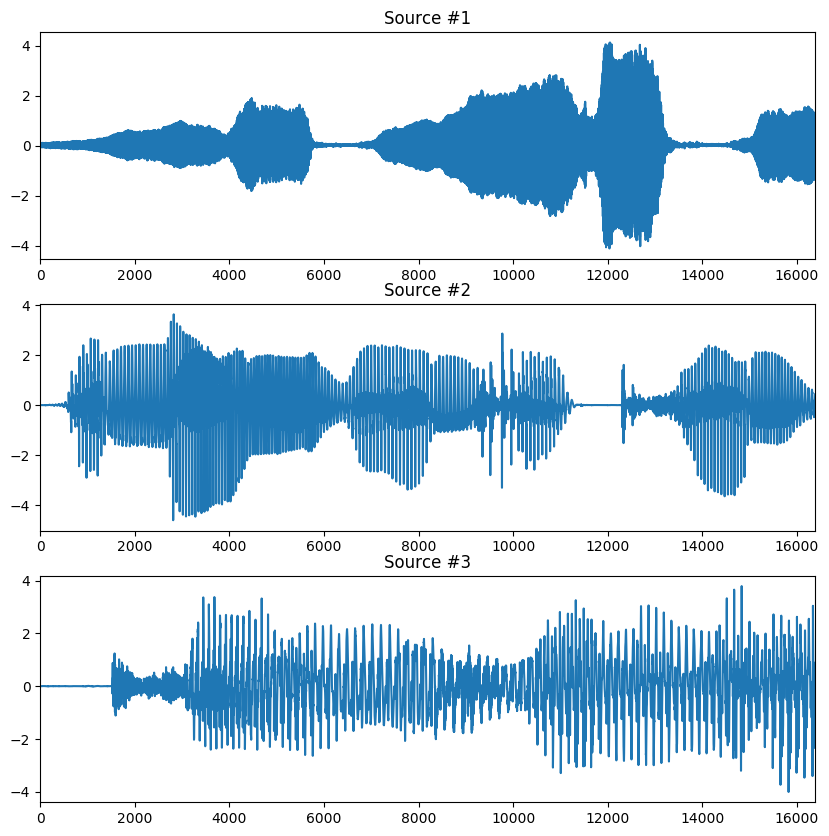

In [7]:
figure(figsize = (10,10))

for i in 1:s
    subplot(s, 1, i)
    plot(x[:, i])
    xlim(0,n)
    title("Source #$i")
end

Display of the micro output.

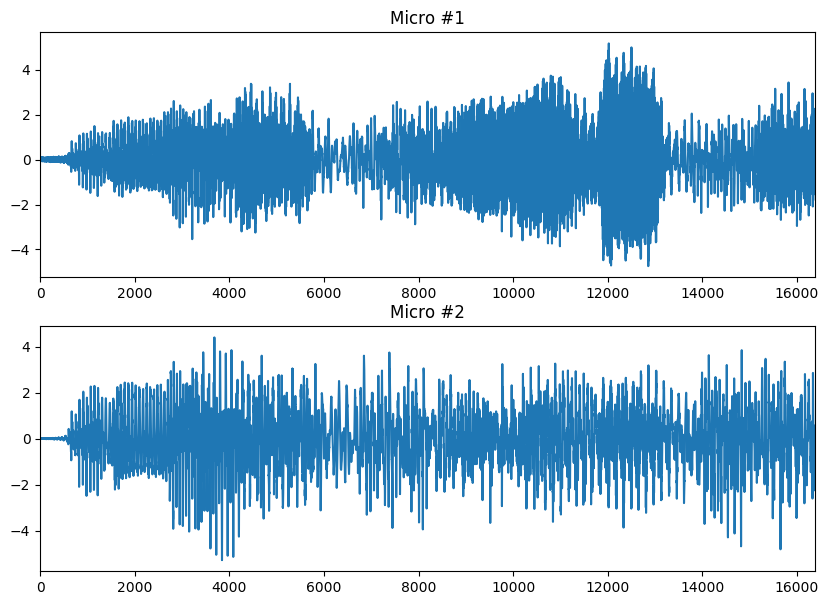

In [8]:
figure(figsize = (10,7))
    
for i in 1:p
    subplot(p, 1, i)
    plot(y[:, i])
    xlim(0,n)
    title("Micro #$i")
end

Local Fourier analysis of sound.
--------------------------------
In order to perform the separation, one performs a local Fourier analysis
of the sound. The hope is that the sources will be well-separated over
the Fourier domain because the sources are sparse after a STFT.




First set up parameters for the STFT.

In [9]:
w = 128   #size of the window
q = Base.div(w,4);  #overlap of the window

Compute the STFT of the sources.

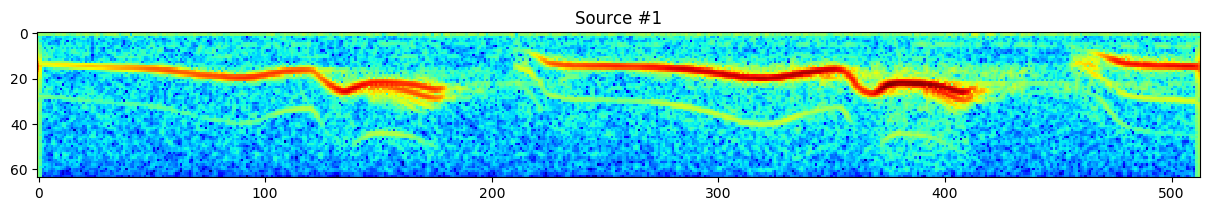

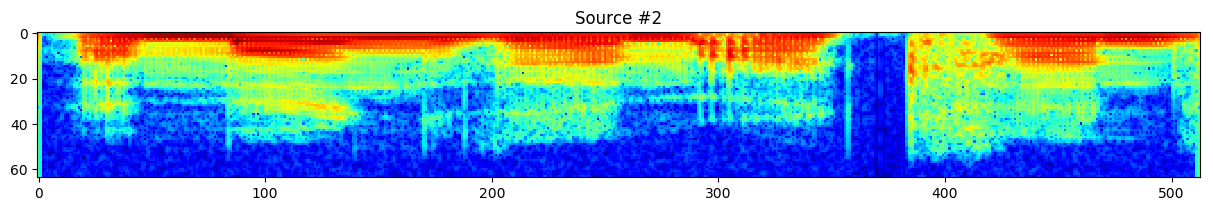

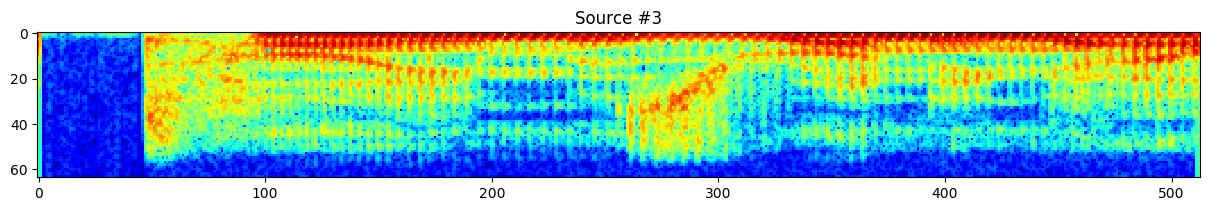

In [10]:
X = complex(zeros(w,4*w+1,s))
Y = complex(zeros(w,4*w+1,p))

for i in 1:s
    X[:,:,i] = perform_stft(x[:,i],w,q,n)
    figure(figsize = (15,10))
    plot_spectrogram(X[:,:,i],"Source #$i")
end

__Exercise 1__

Compute the STFT of the micros, and store them into a matrix |Y|.

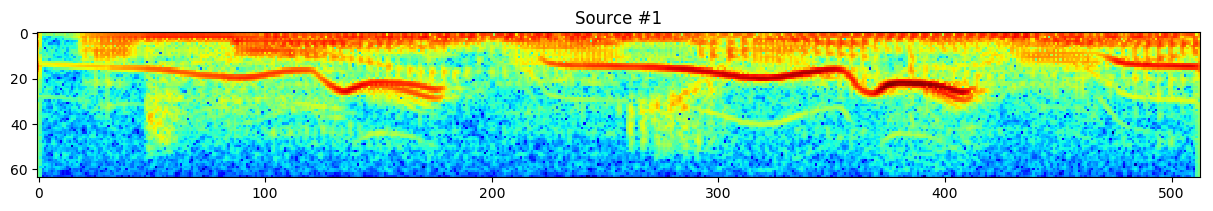

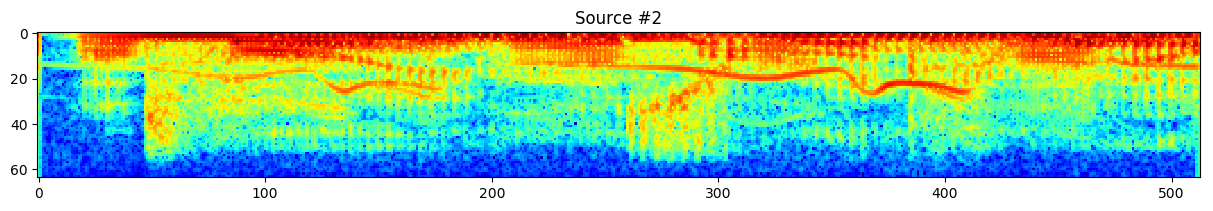

In [11]:
#run -i nt_solutions/audio_2_separation/exo1
include("NtSolutions/audio_2_separation/exo1.jl")

In [12]:
## Insert your code here.

Estimation of Mixing Direction by Clustering
--------------------------------------------
Since the sources are quite sparse over the Fourier plane, the directions
are well estimated by looking as the direction emerging from a point
clouds of the transformed coefficients.


First we compute the position of the point cloud.

In [13]:
mf = size(Y)[1]
mt = size(Y)[2]
P = reshape(Y, (mt*mf,p))
P = vcat(real(P), imag(P));

Then we keep only the 5% points with largest energy.


Display some points in the original (spacial) domain.

Number of displayed points.

In [14]:
npts = 6000;

Display the original points.

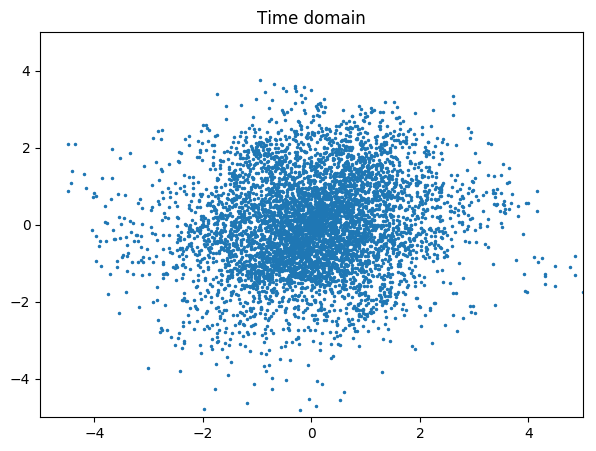

In [15]:
sel = randperm(n)

sel = sel[1:npts]

figure(figsize = (7,5))
plot(y[sel,1], y[sel,2], ".", ms = 3)
xlim(-5,5)
ylim(-5,5)
title("Time domain");

__Exercise 2__

Display some points of $P$ in the transformed (time/frequency) domain.

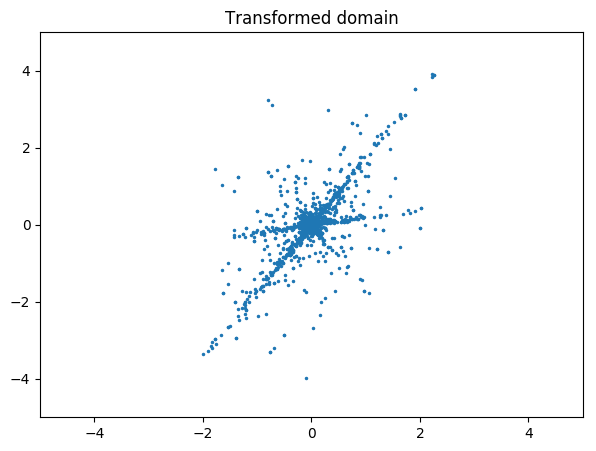

In [16]:
include("NtSolutions/audio_2_separation/exo2.jl");

In [17]:
## Insert your code here.

We compute the angle associated to each point over the transformed
domain. The histogram shows the main direction of mixing.

In [18]:
nrow = size(P)[1]
Theta = zeros(nrow)
for i in 1:nrow
    Theta[i] = mod(atan2(P[i,2],P[i,1]),pi)
end

Display histogram.

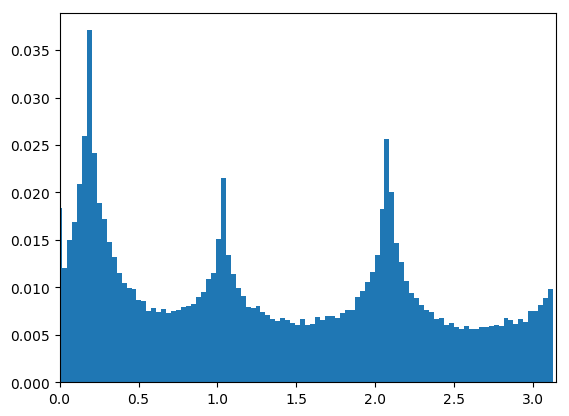

In [19]:
nbins = 100
h,t = plt[:hist](Theta,nbins)
h=h/sum(h)
clf()
bar(t[1:end-1], h, width = pi/nbins)
xlim(0,pi);

__Exercise 3__

The histogram computed from the whole set of points are not peacked
enough. To stabilize the detection of mixing direction, compute an
histogram from a reduced set of point that have the largest amplitude.
Compute the energy of each point. Extract only a small sub-set.

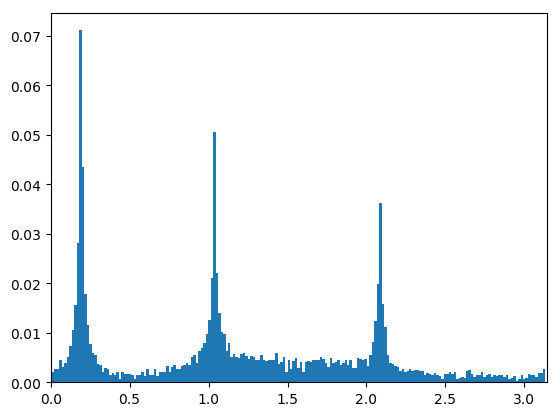

In [20]:
include("NtSolutions/audio_2_separation/exo3.jl");

In [21]:
## Insert your code here.

__Exercise 4__

Detect the direction $M_1$ approximating the true direction $M$ by
looking at the local maxima of the histogram. First detect the set of
local maxima, and then keep only the three largest. Sort in descending order.

In [22]:
include("NtSolutions/audio_2_separation/exo4.jl")

--- M ---
[0.980067 0.5 -0.3; 0.198669 0.866025 0.866025]
--- M1 ---
[0.982243 0.509136 -0.494987; 0.187615 0.860686 0.8689]


In [23]:
## Insert your code here.

Separation of the Sources using Clustering
------------------------------------------
Once the mixing direction are known, one can project the sources on the
direction.


We compute the projection of the coefficients Y on each estimated
direction.

In [24]:
A = reshape(Y, (mt*mf,p));

Compute the projection of the coefficients on the directions.

In [25]:
C = abs(M1'*A');

At each point $x$, the index $I(x)$ is the direction which creates the
largest projection.

$I$ is the index of the closest source.

In [26]:
tmp, I = compute_max(C,1)
I = reshape(I, (mf,mt));

An additional denoising is achieved by removing small coefficients.

In [27]:
T = .05
D = sqrt(sum(abs(Y).^2, 3))[:,:,1]
I = I.*(D .> T);

We can display the segmentation of the time frequency plane.

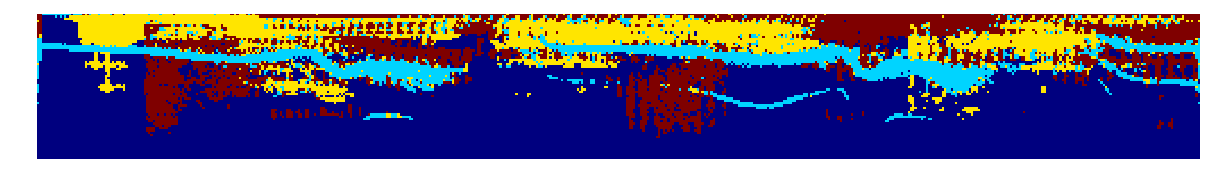

In [28]:
figure(figsize = (15,10))
imageplot(I[1:Base.div(mf,2),:])
imshow(I[1:Base.div(mf,2),:], cmap = get_cmap("jet"), interpolation = "nearest");

The recovered coefficients are obtained by projection.

In [29]:
Proj = M1'*A'
Xr = complex(zeros(w,4*w+1,s))
for i in 1:s
    Xr[:,:,i] = reshape(Proj[i,:], (mf,mt)).*(I .== i)
end

The estimated signals are obtained by inverting the STFT.

In [30]:
xr = zeros(n,s)
for i in 1:s
    xr[:,i] = perform_stft(Xr[:,:,i], w, q, n)
end

One can display the recovered signals.

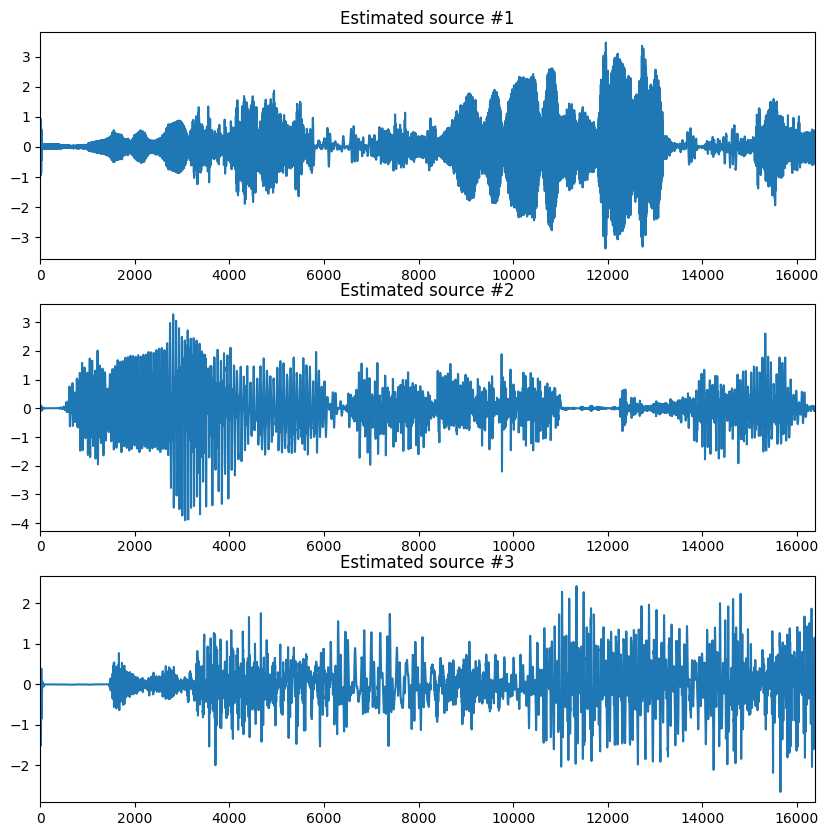

In [31]:
figure(figsize = (10,10))

for i in 1:s
    subplot(s,1,i)
    plot(xr[:,i])
    xlim(0,n)
    title("Estimated source #$i")
end

One can listen to the recovered sources.

In [32]:
i = 1
WAV.wavplay(x[:,i], 15000) # Supported back-ends : AudioQueue (MacOSX) and Pulse Audio (Linux, libpulse-simple). 
#There is not a native backend for Windows yet.

In [33]:
WAV.wavplay(xr[:,i], 15000)